# Rank Based Analysis: (535, 536)
Outlier detection method proposed by Barbara. It is based on these steps: 

1. Order the set by rank on occurrences
2. Extract the subset of values that happens `SENSITIVITY` of the time
3. any value outside [ min(subset), max(subset) ] is an outlier 

Sensitivity is set to:

In [210]:
SENSITIVITY = 0.99

In [211]:
from src import *
from src.models.AlmaClasses import *

from pandas import Series
from pandas import DataFrame
from matplotlib import pyplot
import numpy as np

palette = PaletteFileDB(
    filename='../data/processed/colors-almaAntenna.pkl', 
    colorFunction=paintedForAlmaAntennas )

db = DelaysFileDB( 
    caseName="CaseAntennaObserving", 
    path= '../' + config.FILEPATH_DB + "/delays")  

## Pair to study
As a first example we will study this pair:

In [212]:
(a,b) = (510, 511)
# (a, b) = (543, 544)
# (a, b) = (528, 533)

In [213]:
 "C_%s: %s" % (a, palette.getColors()[a])

'C_510: [CONTROL/${ANT}/FrontEnd/IFSwitch - ] ContainerServices::getComponentNonSticky(CONTROL/${ANT}/IFProc_A)'

In [214]:
"C_%s: %s" % (b, palette.getColors()[b])

'C_511: [CONTROL/${ANT}/FrontEnd/IFSwitch - ] ContainerServices::getComponentNonSticky(CONTROL/${ANT}/IFProc_B)'

`pandas.Series` is used below, it allows handy serie manipulation.

In [215]:
delays = Series(db.getDelays(a,b))

In [216]:
delays.describe()

count    972.000000
mean       8.600823
std        8.608735
min        1.000000
25%        4.000000
50%        7.000000
75%       11.000000
max      214.000000
dtype: float64

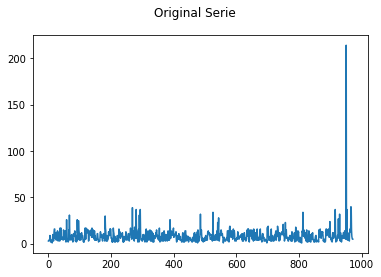

In [217]:
fig = pyplot.figure()
fig.suptitle('Original Serie')
pyplot.plot(delays)
pyplot.show()

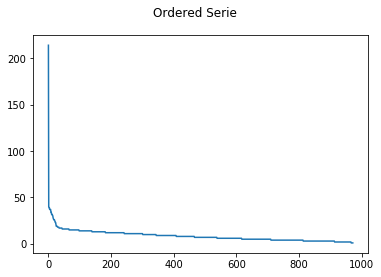

In [218]:
fig = pyplot.figure()
fig.suptitle('Ordered Serie')
# pyplot.yscale('log')
pyplot.plot(sorted(delays, reverse=True))
pyplot.show()

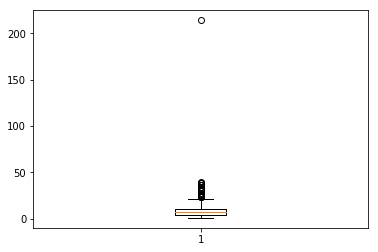

In [219]:
# Simple boxplot
pyplot.boxplot( delays )
pyplot.show()

In [220]:
# DataFrame(delays).boxplot()

## Applying Method
Extracting the rank based on # of occurrences, and make a plot

In [221]:
value_counts = delays.value_counts()

print "Value=%s happens %s times" % (value_counts.index[0], value_counts.values[0])
print "Value=%s happens %s times" % (value_counts.index[1], value_counts.values[1])
print "Value=%s happens %s times" % (value_counts.index[10], value_counts.values[10])


value_counts

Value=4 happens 103 times
Value=3 happens 100 times
Value=10 happens 43 times


4      103
3      100
5       93
6       79
7       72
9       64
12      60
11      59
8       58
2       53
10      43
13      43
14      41
15      32
16      22
17      10
1        6
18       5
19       4
37       4
26       3
31       2
39       2
23       2
34       2
32       2
40       1
27       1
30       1
28       1
25       1
24       1
21       1
214      1
dtype: int64

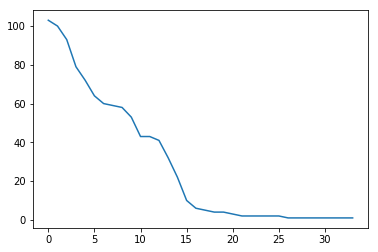

In [222]:
pyplot.plot(value_counts.values)
pyplot.show()

The rank obtained in `value_counts` shows that the evident `outlier=214` happens only 1 time, 41 happens 2 times. Let's see the tail of the ordered original delays: (yes, they are here!)

In [223]:
sorted(delays)[-10:]

[34, 34, 37, 37, 37, 37, 39, 39, 40, 214]

Now, obtain the subset of values that, combined, appears `SENSITIVE` amount of times

In [224]:
# Cumulative sum on value_counts.
cumsum = value_counts.cumsum()

In [225]:
total = cumsum[-1:].values[0]
total

972

In [226]:
percentageCumsum = cumsum / total

In [227]:
# Note that this method is simpler, but the very explicit results with percentageCumsum is shown for clarity
#typicalValues = cumsum[ cumsum <= SENSITIVITY * total ]

typicalValues = percentageCumsum[ percentageCumsum <= SENSITIVITY]
typicalValues

4     0.105967
3     0.208848
5     0.304527
6     0.385802
7     0.459877
9     0.525720
12    0.587449
11    0.648148
8     0.707819
2     0.762346
10    0.806584
13    0.850823
14    0.893004
15    0.925926
16    0.948560
17    0.958848
1     0.965021
18    0.970165
19    0.974280
37    0.978395
26    0.981481
31    0.983539
39    0.985597
23    0.987654
34    0.989712
dtype: float64

In [228]:
minVal, maxVal = min(typicalValues.index), max(typicalValues.index)
minVal, maxVal

(1, 39)

# Testing the method
A graph with the "typical" part (minVal < t < maxVal) is shown, with some stats metrics.

In [229]:
typicalDelays = delays[ minVal <= delays ][ delays <= maxVal ]
typicalDelays.describe()

count    970.000000
mean       8.356701
std        5.444966
min        1.000000
25%        4.000000
50%        7.000000
75%       11.000000
max       39.000000
dtype: float64

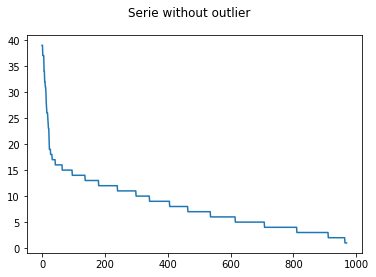

In [230]:
fig = pyplot.figure()
fig.suptitle('Serie without outlier')
pyplot.plot(sorted(typicalDelays, reverse=True))
pyplot.show()

Found Outliers:

In [231]:
"%s of %s (%.3f%%)" % ( len(delays) - len(typicalDelays), len(delays), 100*(1.0*len(delays) - len(typicalDelays))/len(delays) )

'2 of 972 (0.206%)'

In [232]:
delays[ delays < minVal ].values

array([], dtype=int64)

In [233]:
delays[ maxVal < delays ].sort_values().values

array([ 40, 214])

In [234]:
# All the above in one function
def minmax_rank_based( values, sensitivity ):
    value_counts = Series(values).value_counts()
    cumsum = value_counts.cumsum()
    typicalValues = cumsum[ cumsum <= sensitivity * value_counts.sum() ]
    return min(typicalValues.index), max(typicalValues.index)

In [235]:
minmax_rank_based( db.getDelays(510,511), SENSITIVITY )

(1, 39)

## Discussion
The minmax_rank_based function uses parameter S, the sensitivity. Playing with S from 0.80 to 0.99 means removing outliers from 1% to 20% of the data, and can give insights on how stable the AB-serie is. 

In [243]:
changingSensitivity=[ minmax_rank_based( db.getDelays(510,511), 0.8 + S/100.0 ) for S in range(1, 20) ]

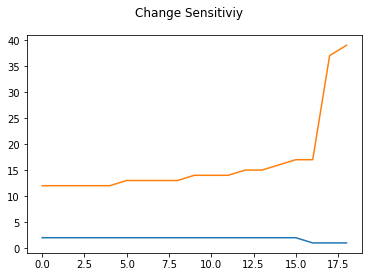

In [244]:
fig = pyplot.figure()
fig.suptitle('Change Sensitiviy')
pyplot.plot(changingSensitivity)
pyplot.show()

In [245]:
changingSensitivity

[(2, 12),
 (2, 12),
 (2, 12),
 (2, 12),
 (2, 12),
 (2, 13),
 (2, 13),
 (2, 13),
 (2, 13),
 (2, 14),
 (2, 14),
 (2, 14),
 (2, 15),
 (2, 15),
 (2, 16),
 (2, 17),
 (1, 17),
 (1, 37),
 (1, 39)]